# 2022 Systematic Trading Education Ceritificate Skeleton Code for the Coursework


## Introduction
The code included in this Notebook is the same skeleton code that we discussed in session 1 of the lecture series and the task of this coursework will be for you to write your own strategy and backtest it as we did for basic relative and time series momentum in the first lecture.

In [91]:
#pip install yfinance

In [92]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import datetime

## The Parent Class and Evaluation function.
In the code below we define the Strategies class which is a class containing all basic features that our individual backtesting strategy classes will inherit from.

These basic features include:

- the **init method** which defines the asset tickers that the strategy will be focussed on.
- the **import data method** that will import data for a given start and end date using the yfinance module as mentioned earlier.
- the **backtest method** that defines the class variable self.strat which is the pandas data frame of values representing the strategy. This is left empty as it will be filled in in the child class.
- the **evaluate method** which calculates the cumulative returns of the given strategy, plots a chart of the cumulative returns and calculates the sharpe ratio of the strategy.
(note that one task this week will be to write code in the evaluate method so that it also returns the sortino ratio)

In [93]:
####### THIS CODE IS THE SAME AS THE SKELETON CODE THAT WE COMPLETED IN THE FIRST LECTURE ########
####### PLEASE DON'T MESS WITH THIS CODE BLOCK AS IT WILL MAKE MARKING AN ABSOLUTE BALL-ACHE!!!!! #########
class Strategies():
  """
  A class that contains code that strategies later on will inherit from.
  params:
  -----
  codes = list of stock short codes
  -----
  """
  def __init__(self, codes):
    self.codes = codes
    self.strat = pd.DataFrame()
    self.data = pd.DataFrame()

  def import_data(self, start_date, end_date):
    """downloads all data for each backtest from yahoo Finance."""
    data = yf.download(self.codes, start_date, end_date)
    # if only one stock code is entered data is reformated so that
    # it is the same format as when multiple stocks are entered
    if len(self.codes) == 1:
      data.columns = [data.columns, self.codes*len(data.columns)]
    #returns data where any row containing NAN values is removed
    return data.dropna()

  def backtest(self, start_date, end_date):
    """
    Returns a list with elements of a time series' from yahoo finance as well as
    an array of values between -1 and 1 that represent the strategy over the giv
    en period with 1 representing a long postion in one stock, 0 representing a
    neutral postion and -1 representing a short position.
    params:
    -----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    -----
    """
    # sets up a dataframe to contain all strategy info for each stock at each 
    # time index
    self.data = self.import_data(start_date, end_date)
    self.strat = pd.DataFrame(data = np.zeros([len(self.data), len(self.codes)]),
                              columns = self.codes, index = self.data.index)
  
  def evaluate(self, start_date, end_date, fig_strat=True, fig_other=False,
               percentage_risk_free_rate = 0.1, **kwargs):
    """
    returns a dataframe with columns icluding the daily returns of the portfolio,
    the cumulative returns, the sharp ratio and all relevant plots of both the 
    stock price of each stock 
    and the strategy.
    params:
    ----
    start_date, end_date  = string of dates for backtesting with format Y-m-d
    fig = boolean variable that can be used to produce figures
    risk_free_rate = average rate of return on a very safe government issued bond
                     used to calculate the sharpe ratio with
    **kwargs are any specific keyword arguments that can be passed to the
    backtesting function to allow for comparison of the backtest for different
    possible parameters defined in the subclass.
    ----
    """
    # convert the monthly risk free rate to the daily rate for use
    # when calculating Sharpe and sortino ratios
    daily_rate = (1+ percentage_risk_free_rate/100)**(1/20) - 1
    # run the backtest function and define the stock price data to be once again
    # self.data and the signals self.strat
    strat = self.backtest(start_date, end_date, **kwargs)
    
    # sets up a new dataframe which will give the returns of the portfolio
    return_df = pd.DataFrame(columns= ["daily returns", "cumulative returns"],
                                  index = self.data.index)
    return_df["daily returns"][0] = 0
    
    # loops through the remaining dates and calculates the return across 
    # the portfolio
    for i in range(1, len(self.data)):
      return_df["daily returns"][i] = sum(100*self.strat[c][i-1]*(self.data["Adj Close"][c][i] - self.data["Adj Close"][c][i-1]) 
                                               /self.data["Adj Close"][c][i-1] for c in self.codes)
    # calculates the cumulative return for each date
    return_df["cumulative returns"] = ((return_df["daily returns"]/100+1).cumprod()-1)*100
    return_df.dropna()

    # calculates the sharpe ratio based on a low risk asset
    zero_count = 0
    while True:
      if sum(abs(self.strat[c].iloc[zero_count]) for c in self.codes):
        break
      zero_count += 1

    sharpe  = ((return_df["daily returns"][zero_count:].sum()/100 - 
                     len(return_df[zero_count:]) * daily_rate) /
                    return_df["daily returns"][zero_count:].std())


    sortino = ((return_df["daily returns"][zero_count:].sum()/100 - 
                     len(return_df) * daily_rate) /
                    return_df["daily returns"][(return_df["daily returns"] < 0)].std())
    
    
    #plots figures if fig TRUE
    if fig_strat:
      # plot of strategy returns
      plt.figure()
      plt.title("Strategy Backtest from "+ start_date+" to "+end_date)
      plt.plot(return_df["cumulative returns"])
      plt.show()

    if fig_other:
      # plot of all individual stocks
      for c in self.codes:
        plt.figure()
        plt.title("Buy and hold from "+ start_date+" to "+end_date+" for "+str(c))
        plt.plot(((self.data["Adj Close"][c].pct_change()+1).cumprod()-1)*100)
        plt.show()
    
    return [return_df, sharpe, sortino]


## Strategy Specific Classes
Each strategy will have to have at a minimum a specific backtesting method defined in the subclass. This method is where the trading algorithm will be implemented and will return a pandas dataframe with an index of all trading dates, columns for each stock in the backtest and data containing values between -1 and 1 representing the positon in each asset at each date.

## Buy and Hold Implementation
The first strategy example that we will brifly look at is simply buying and holding each selected asset with an equal weighting. This is acheived by first defining a pandas dataframe full of ones and then dividing through by the number of tickers (or codes). Although this isn't much of an algorithm, it is useful for seeing how the skeleton code works. 

In [94]:
class StrategyBuyAndHold(Strategies):
    """
    This strategy as the name suggests buys and holds an equal amount of each security
    """
    def backtest(self, start_date, end_date):
      Strategies.backtest(self, start_date, end_date)
      # creates a normalized set of weightings representing a buy and hold strat
      #with each column summing to one 
      self.strat = pd.DataFrame(data = (np.ones([len(self.data), len(self.codes)])
                    /len(self.codes)), columns = self.codes)
      return self.strat
      


[*********************100%***********************]  1 of 1 completed


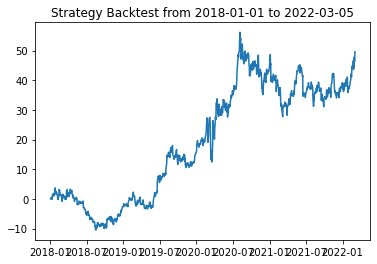

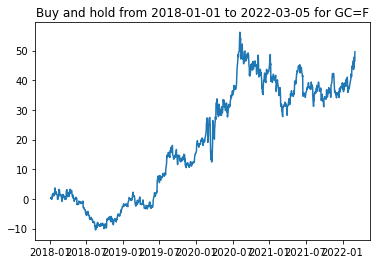

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03      0.190302           0.190302
 2018-01-04       0.24313           0.433895
 2018-01-05      0.068215           0.502405
 2018-01-08     -0.128764           0.372994
 ...                  ...                ...
 2022-02-28      0.683807          44.584007
 2022-03-01      2.263873          47.857205
 2022-03-02     -1.106878          46.220606
 2022-03-03      0.702796          47.248238
 2022-03-04      1.587053          49.585145
 
 [1051 rows x 2 columns],
 0.4154884089975461,
 0.5383114643026704]

In [95]:
# testing of the buy and hold strategy
testbh = StrategyBuyAndHold(["GC=F"])
testbh.evaluate("2018-01-01","2022-03-05", fig_other=True)

## Coursework Task
****
As we were unable to cover this topic in lectures the aim of this coursework will be to code up a moving average model. The concept behind this model involves comparing the short term moving average (e.g average over the last 5 days) with a long term moving average (e.g average over the last 200 days) at each time point. This comparison is what produces buy/sell signals.
****
### Strategy Outline
This strategy has 2 parameters. 
- **s** - the lookback period for calculating the moving average over a **short** time period.
- **l** - the lookback period for calculating the moving average over a **large** time period.

At each time instance it is necessary to calculate the simple moving average of the previous **s** and **l** asset prices. To do this in code you could for example do ***self.data["Adj Close"][c][i-s:i].mean()*** i,e calculate the mean of the previous s values at time step i for stock code or ticker c.

Then if the short moving average crosses the long moving average i.e the value of the **small time period MA is greater than the large time period MA** then this is a **buy** signal. Otherwise enter a neutral position. (for this strategy there will be **no short selling**) 

For an individual security at a ceratin time point a buy signal corresponds to a positive value in self.strat and a neutral postion corresponds to a 0. Remember to also normalize across each row of self.strat as was done in the time series momentum strategy in lecture 1.
****
### Extension
An optional part of the coursework will be to extend the complexity of the strategy. You are free to investigate or develop any extra code that you like although I will include a few examples of how to extend the above model:
- Instead of using simple moving average's try to code **exponential moving averages** or attempt to use **Kauffmann's adoptive moving average**. For more info on this check out https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/kaufmans-adaptive-moving-average-kama/
- Implement a **weighting scheme**.
- Investigate how **varying the parameters** of the number of days used in calculating moving averages effects returns and/or volatilty. Try discussing how you would tune the parameters in the question.

If you do decide to complete an extension please include a brief summary of what it is you aim to implement in a text block and try to make your code readable by including comments etc... .

**For those attempting an extension make sure all the code is error free or else we will not be able to mark your extra code.**
****
### Marking
The coursework will be marked out of 30 with 20 marks for completing the basic strategy and the remaining 10 marks for extending on the strategy as discussed above.

The 20 marks for the basic strategy will be awarded for the following:
- Getting something that works as described above **(10 marks)**

- Usage of **Pandas and Numpy** to optimise how the code runs. For example there are lots of useful inbuilt pandas and numpy functions that can make your code considerably shorter and easier to follow including ***pd.rolling(), pd.pct_change()*** to name a couple. The following 2 links are for the pandas and numpy documentation repsectively, https://pandas.pydata.org/docs/ and https://numpy.org/doc/ **(5 marks)**

- Readability of the code and efficiency. Try to include a few comments although don't go overboard. **(3 marks)**

- A brief summary of how the code works. This can be written in a text cell below below where you have written your strategy code. **(2 marks)**
****
**On completion of the coursework and accompanying quiz candiates will recieve a grade of either a pass, merit or distinction.**

**To submit your coursework you should upload your final work to the microsoft form given in the email**

In [117]:
class StrategySMA(Strategies):
  """
  An implementation of the simple moving average crossover strategy
  """
  def backtest(self, start_date, end_date, s=10, l=400):
    """
    s is the length of the shorter time period,
    l is the length of the longer time period.
    """
    Strategies.backtest(self, start_date, end_date)

    #calculate short&long-window SMA dataframes
    short_rolling = self.data["Adj Close"].rolling(window = s,min_periods = 1).mean() 
    long_rolling = self.data["Adj Close"].rolling(window = l,min_periods = 1).mean()

    #simply subtract long-rolling from short rolling to get positions dataframe
    positions = (short_rolling-long_rolling)

    #for each signal, in the event of a net positive result, set to buy signal(1) otherwise remain neutral 
    for col in self.codes:
      positions[col] = positions[col].apply(lambda x : 1 if x>0 else 0)

    #normalise row
    for i in range(len(positions)):
      row_sum = sum((abs(positions[c][i]) for c in self.codes))

      if row_sum:
        positions.iloc[i] /= row_sum

    #set to self.strats and return
    self.strat = positions
    return self.strat


[*********************100%***********************]  3 of 3 completed


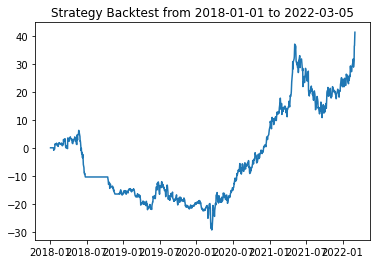

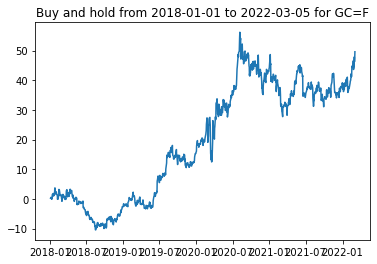

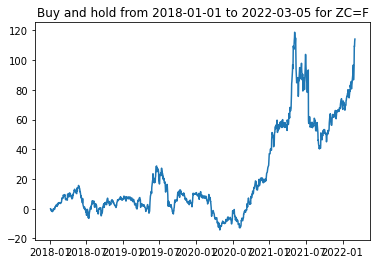

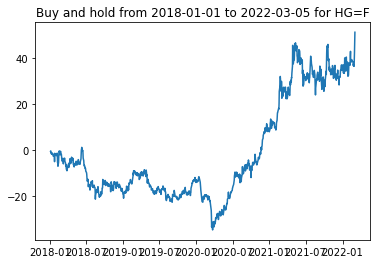

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04           0.0                0.0
 2018-01-05           0.0                0.0
 2018-01-08           0.0                0.0
 ...                  ...                ...
 2022-02-28      1.943602          31.337773
 2022-03-01      3.838728          36.379473
 2022-03-02      0.098715          36.514101
 2022-03-03      1.617374          38.722044
 2022-03-04      1.862244          41.305387
 
 [1048 rows x 2 columns],
 0.33724626540267966,
 0.4698081900308176]

In [119]:
# testing of the moving average crossover strategy
testsma = StrategySMA(["GC=F","ZC=F","HG=F"],)
testsma.evaluate("2018-01-01","2022-03-05", fig_other=True)

To implement the extension method discussed above feel free to add any extra code and text blocks to help with your strategy and analysis.


## EXTENSION: Using Exponential Moving Average

Using SMA, the calculated timeseries price lags the original original price timeseries. This lag is roughly $\frac{s}{2}$ days. For longer SMA, delays will become quite significant and be a detriment to the strategy.

Reducing lag can be done using EMA, exponential moving averages, as it puts more weight on recent observations, compared to SMA where all observations are weighted equally by $\frac{1}{s}$. This makes them more reliable as they are a better indication of a stock's recent performance.

The EMA works similarly to the SMA strategy overall, it's just the method of calculating the average is different.


[*********************100%***********************]  3 of 3 completed


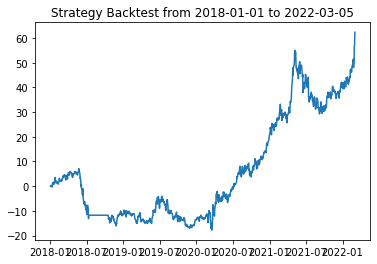

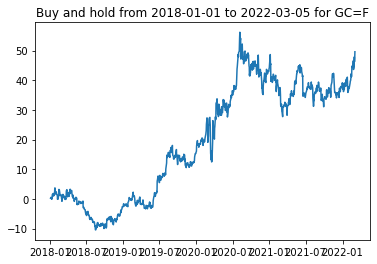

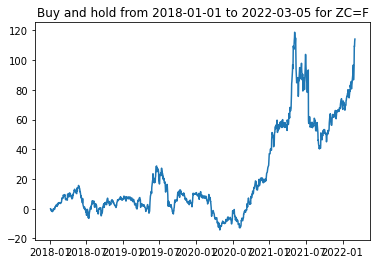

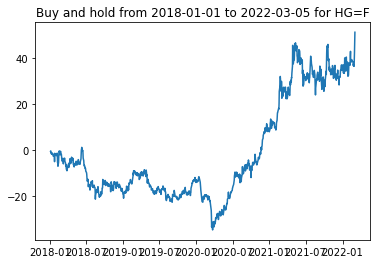

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04       0.24313            0.24313
 2018-01-05      0.068215            0.31151
 2018-01-08     -0.128764           0.182345
 ...                  ...                ...
 2022-02-28      1.943602           50.86403
 2022-03-01      3.838728           56.65529
 2022-03-02      0.098715          56.809933
 2022-03-03      1.617374          59.346136
 2022-03-04      1.862244           62.31355
 
 [1048 rows x 2 columns],
 0.4827875572027117,
 0.6762324194340372]

In [122]:
class StrategyEMA(Strategies):
  """
  An implementation of the moving exponential crossover strategy
  """
  def backtest(self, start_date, end_date, s=40, l=400): #s=span
    """
    s is the length of the shorter time period,
    l is the length of the longer time period.
    """
    Strategies.backtest(self, start_date, end_date)

    #calculate short&long-window SMA dataframes
    short_rolling = self.data["Adj Close"].ewm(span=s, adjust=False).mean() 
    long_rolling = self.data["Adj Close"].ewm(span=l, adjust=False).mean() 


    #simply subtract long-rolling from short rolling to get positions dataframe
    positions = (short_rolling-long_rolling)

    #for each signal, in the event of a net positive result, set to buy signal(1) otherwise remain neutral 
    for col in self.codes:
      positions[col] = positions[col].apply(lambda x : 1 if x>0 else 0)

    #normalise row
    for i in range(len(positions)):
      row_sum = sum((abs(positions[c][i]) for c in self.codes))

      if row_sum:
        positions.iloc[i] /= row_sum

    # print("Positions:")
    # print(positions)
    #set to self.strats and return
    self.strat = positions
    return self.strat
      

# testing of the exponential moving average crossover strategy
testema = StrategyEMA(["GC=F","ZC=F","HG=F"],)
testema.evaluate("2018-01-01","2022-03-05", fig_other=True)

We can see that the EMA strategy nets greater returns than the SMA strategy (the latter performing worse than buying and holding). It is also interesting to note that both moving average strategies ended up with a greater return at the end than the peak near the middle, unlike the buy-hold strat. 

## EXTENSION: Using Exponential Moving Average + Implementing weights

Any positive position (short-rolling minus long-rolling) is replaced with a constant buy signal of equal weighting. We can use a simple square-root-style regression to prioritise asset tickers with higher positions than the others (greater net positive positions are given greater weighting). Instead of replacing it with a constant buy signal, we can use a signal equal to the square root of the net position, and then normalise across the row.


[*********************100%***********************]  3 of 3 completed


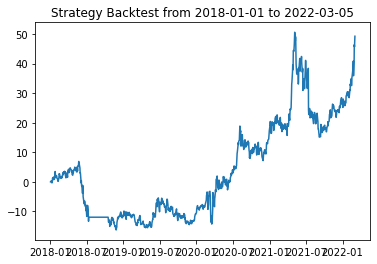

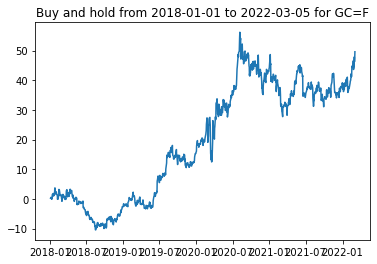

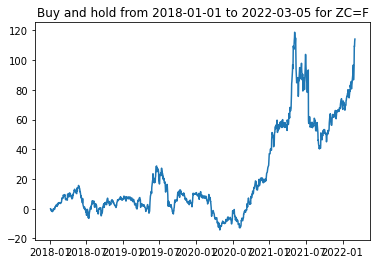

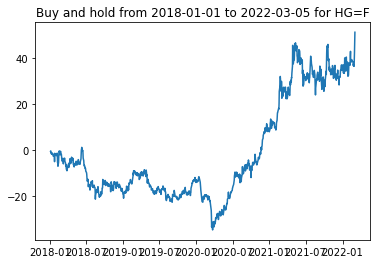

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04       0.24313            0.24313
 2018-01-05      0.068215            0.31151
 2018-01-08     -0.128764           0.182345
 ...                  ...                ...
 2022-02-28      3.294826          40.336708
 2022-03-01      4.283194          46.347602
 2022-03-02     -0.487865          45.633623
 2022-03-03      1.265177          47.476147
 2022-03-04      1.183753            49.2219
 
 [1048 rows x 2 columns],
 0.3694775976008901,
 0.45683867310314336]

In [143]:
class StrategyEMAWeighted(Strategies):
  """
  An implementation of the moving exponential crossover strategy
  """
  def backtest(self, start_date, end_date, s=40, l=400): #s=span
    """
    s is the length of the shorter time period,
    l is the length of the longer time period.
    """
    Strategies.backtest(self, start_date, end_date)

    #calculate short&long-window SMA dataframes
    short_rolling = self.data["Adj Close"].ewm(span=s, adjust=False).mean() 
    long_rolling = self.data["Adj Close"].ewm(span=l, adjust=False).mean() 


    #simply subtract long-rolling from short rolling to get positions dataframe
    positions = (short_rolling-long_rolling)

    #for each signal, in the event of a net positive result, set to buy signal of sqrt(x) otherwise remain neutral (0)
    for col in self.codes:
      positions[col] = positions[col].apply(lambda x : 0 if x<0 else x**0.5)

    #normalise row
    for i in range(len(positions)):
      row_sum = sum((abs(positions[c][i]) for c in self.codes))

      if row_sum:
        positions.iloc[i] /= row_sum

    # print("Positions:")
    # print(positions)
    #set to self.strats and return
    self.strat = positions
    return self.strat
      

# testing of the exponential moving average crossover strategy
testema = StrategyEMAWeighted(["GC=F","ZC=F","HG=F"],)
testema.evaluate("2018-01-01","2022-03-05", fig_other=True)

This method somehow reduces returns, however (this weighting does not help with diversification of assets). I am not proceeding with a weighted model.

## EXTENSION: Varying the Long/Short window durations (non-weighted)

### Final Returns

|       	| s=10 	| s=20 	| s=30 	|
|:-----:	|:----:	|:----:	|:----:	|
| l=100 	| ≈126 	| ≈199 	| ≈174 	|
| l=200 	| ≈153 	| ≈163 	| ≈158 	|
| l=300 	| ≈156 	| ≈136 	| ≈145 	|

Setting s=20 and l=100 seems to net the highest return, however I speculate that this is just an optimised overfit to the current data time period as the other return values aren't too far off either.

In other EMA tutorials I've seen, setting s=20 seems to be a common theme here. A lot of the returns here are dependant on the asset choice, tech stocks and the S&P500 are contributing a lot and are on an upward trend during this period. Quite curiously, I will try use my weighted strategy for s=20 and l=100: the final return is 182. (it sucks)

Feel free to ignore below diagrams, they're just there for proof. Referring to the table is much easier.

[*********************100%***********************]  15 of 15 completed


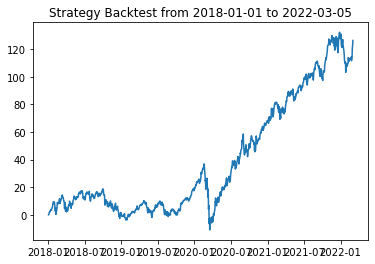

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04      0.422976           0.422976
 2018-01-05      1.140457           1.568258
 2018-01-08       0.77615           2.356579
 ...                  ...                ...
 2022-02-28      1.498646         114.848321
 2022-03-01      2.588349         120.409345
 2022-03-02      0.588743         121.706989
 2022-03-03      1.163498         124.286546
 2022-03-04      0.936478         126.386939
 
 [1048 rows x 2 columns],
 0.6045436595135977,
 0.7032836463730338]

In [126]:
testema = StrategyEMA(["GC=F","ZC=F","HG=F", "AAPL",'^GSPC', 'MSFT', 'GOOG', 'AMZN', 'FB', 'INTC', 'TSLA', 'NVDA', 'CSCO', 'ORCL', 'NFLX'])
testema.evaluate("2018-01-01","2022-03-05", fig_other=False, s=10, l=100)

[*********************100%***********************]  15 of 15 completed


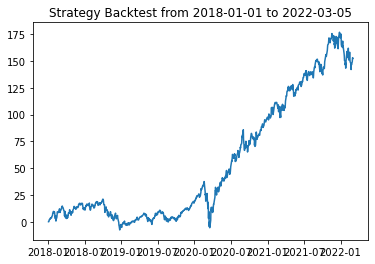

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04      0.422982           0.422982
 2018-01-05      1.140462           1.568268
 2018-01-08      0.776144           2.356584
 ...                  ...                ...
 2022-02-28      0.961828         148.699615
 2022-03-01      0.343322         149.553455
 2022-03-02      1.318749         152.844438
 2022-03-03      0.083847         153.056441
 2022-03-04     -0.303198         152.289179
 
 [1048 rows x 2 columns],
 0.6625576677416306,
 0.7934999332608925]

In [128]:
testema = StrategyEMA(["GC=F","ZC=F","HG=F", "AAPL",'^GSPC', 'MSFT', 'GOOG', 'AMZN', 'FB', 'INTC', 'TSLA', 'NVDA', 'CSCO', 'ORCL', 'NFLX'])
testema.evaluate("2018-01-01","2022-03-05", fig_other=False, s=10, l=200)

[*********************100%***********************]  15 of 15 completed


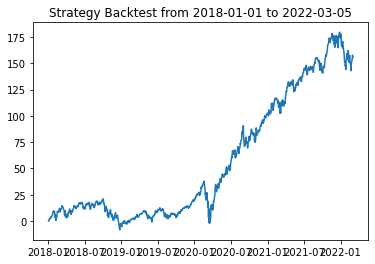

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04      0.422983           0.422983
 2018-01-05      1.140453            1.56826
 2018-01-08      0.776151           2.356583
 ...                  ...                ...
 2022-02-28      1.446408         153.848183
 2022-03-01      0.050302         153.975874
 2022-03-02      1.420979         157.584817
 2022-03-03     -0.446891         156.433695
 2022-03-04     -0.333814         155.577684
 
 [1048 rows x 2 columns],
 0.6699408019772113,
 0.8105717511861162]

In [129]:
testema = StrategyEMA(["GC=F","ZC=F","HG=F", "AAPL",'^GSPC', 'MSFT', 'GOOG', 'AMZN', 'FB', 'INTC', 'TSLA', 'NVDA', 'CSCO', 'ORCL', 'NFLX'])
testema.evaluate("2018-01-01","2022-03-05", fig_other=False, s=10, l=300)

[*********************100%***********************]  15 of 15 completed


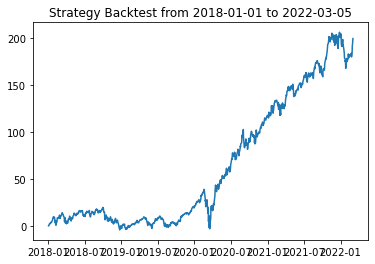

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04      0.422977           0.422977
 2018-01-05      1.140458           1.568259
 2018-01-08      0.776149            2.35658
 ...                  ...                ...
 2022-02-28      1.498646         183.977504
 2022-03-01      2.588349         191.327833
 2022-03-02      0.588743         193.043004
 2022-03-03      1.163498         196.452554
 2022-03-04      0.936478         199.228766
 
 [1048 rows x 2 columns],
 0.7826797814591073,
 0.9522433957452227]

In [130]:
testema = StrategyEMA(["GC=F","ZC=F","HG=F", "AAPL",'^GSPC', 'MSFT', 'GOOG', 'AMZN', 'FB', 'INTC', 'TSLA', 'NVDA', 'CSCO', 'ORCL', 'NFLX'])
testema.evaluate("2018-01-01","2022-03-05", fig_other=False, s=20, l=100)

[*********************100%***********************]  15 of 15 completed


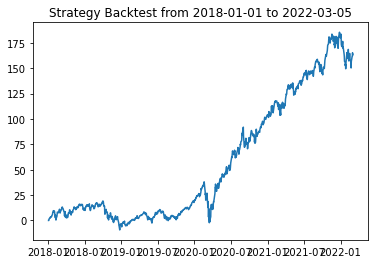

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04       0.42298            0.42298
 2018-01-05      1.140462           1.568265
 2018-01-08      0.776147           2.356584
 ...                  ...                ...
 2022-02-28      1.446408          161.44118
 2022-03-01      0.050302          161.57269
 2022-03-02      1.371724         165.160746
 2022-03-03      -0.43816         163.998918
 2022-03-04     -0.282748         163.252466
 
 [1048 rows x 2 columns],
 0.6888092399337012,
 0.8348395722247485]

In [131]:
testema = StrategyEMA(["GC=F","ZC=F","HG=F", "AAPL",'^GSPC', 'MSFT', 'GOOG', 'AMZN', 'FB', 'INTC', 'TSLA', 'NVDA', 'CSCO', 'ORCL', 'NFLX'])
testema.evaluate("2018-01-01","2022-03-05", fig_other=False, s=20, l=200)

[*********************100%***********************]  15 of 15 completed


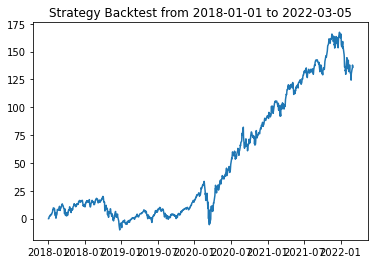

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04      0.422982           0.422982
 2018-01-05      1.140454            1.56826
 2018-01-08      0.776151           2.356582
 ...                  ...                ...
 2022-02-28      1.446408         134.444347
 2022-03-01      0.050302         134.562277
 2022-03-02      1.420979         137.895357
 2022-03-03     -0.446891         136.832225
 2022-03-04     -0.333814         136.041647
 
 [1048 rows x 2 columns],
 0.6141150861491533,
 0.7408712436581368]

In [132]:
testema = StrategyEMA(["GC=F","ZC=F","HG=F", "AAPL",'^GSPC', 'MSFT', 'GOOG', 'AMZN', 'FB', 'INTC', 'TSLA', 'NVDA', 'CSCO', 'ORCL', 'NFLX'])
testema.evaluate("2018-01-01","2022-03-05", fig_other=False, s=20, l=300)

[*********************100%***********************]  15 of 15 completed


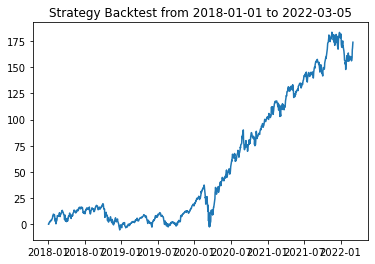

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04      0.422983           0.422983
 2018-01-05      1.140454           1.568261
 2018-01-08      0.776152           2.356585
 ...                  ...                ...
 2022-02-28      1.498646         159.933628
 2022-03-01      2.588349         166.661617
 2022-03-02      0.588743         168.231567
 2022-03-03      1.163498         171.352437
 2022-03-04      0.936478         173.893592
 
 [1048 rows x 2 columns],
 0.7259576097390186,
 0.8713903885695417]

In [133]:
testema = StrategyEMA(["GC=F","ZC=F","HG=F", "AAPL",'^GSPC', 'MSFT', 'GOOG', 'AMZN', 'FB', 'INTC', 'TSLA', 'NVDA', 'CSCO', 'ORCL', 'NFLX'])
testema.evaluate("2018-01-01","2022-03-05", fig_other=False, s=30, l=100)

[*********************100%***********************]  15 of 15 completed


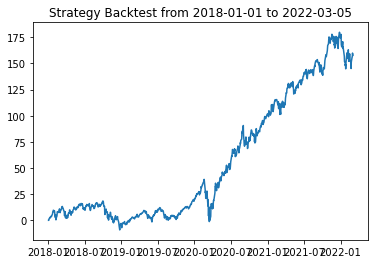

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04      0.422979           0.422979
 2018-01-05      1.140453           1.568256
 2018-01-08      0.776149           2.356576
 ...                  ...                ...
 2022-02-28      1.446408         156.094757
 2022-03-01      0.050302         156.223577
 2022-03-02      1.420979          159.86446
 2022-03-03     -0.446891          158.70315
 2022-03-04     -0.333814         157.839563
 
 [1048 rows x 2 columns],
 0.6747372461378189,
 0.8195774378434408]

In [134]:
testema = StrategyEMA(["GC=F","ZC=F","HG=F", "AAPL",'^GSPC', 'MSFT', 'GOOG', 'AMZN', 'FB', 'INTC', 'TSLA', 'NVDA', 'CSCO', 'ORCL', 'NFLX'])
testema.evaluate("2018-01-01","2022-03-05", fig_other=False, s=30, l=200)

[*********************100%***********************]  15 of 15 completed


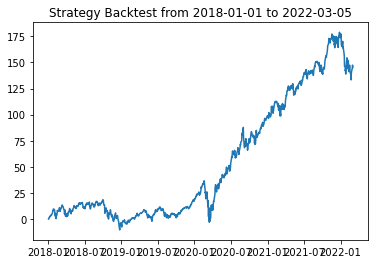

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04       0.42298            0.42298
 2018-01-05      1.140459           1.568263
 2018-01-08      0.776149           2.356584
 ...                  ...                ...
 2022-02-28       1.26967          143.82678
 2022-03-01      0.050302         143.949429
 2022-03-02      1.420979         147.415899
 2022-03-03     -0.446891          146.31022
 2022-03-04     -0.333814         145.488003
 
 [1048 rows x 2 columns],
 0.637360677547447,
 0.7704434422428131]

In [135]:
testema = StrategyEMA(["GC=F","ZC=F","HG=F", "AAPL",'^GSPC', 'MSFT', 'GOOG', 'AMZN', 'FB', 'INTC', 'TSLA', 'NVDA', 'CSCO', 'ORCL', 'NFLX'])
testema.evaluate("2018-01-01","2022-03-05", fig_other=False, s=30, l=300)

[*********************100%***********************]  15 of 15 completed


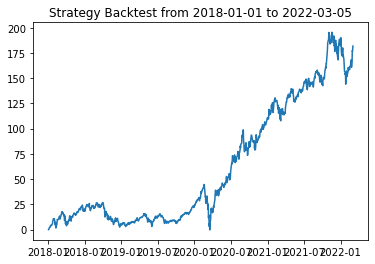

[           daily returns cumulative returns
 Date                                       
 2018-01-02             0                0.0
 2018-01-03           0.0                0.0
 2018-01-04      0.379331           0.379331
 2018-01-05      1.167032            1.55079
 2018-01-08      0.779155           2.342028
 ...                  ...                ...
 2022-02-28      2.739299         167.923172
 2022-03-01      3.459749         177.192642
 2022-03-02     -0.245963         176.510851
 2022-03-03      1.054067          179.42546
 2022-03-04      0.848739         181.797053
 
 [1048 rows x 2 columns],
 0.7521112607169518,
 0.9078031182581947]

In [140]:
testema = StrategyEMAWeighted(["GC=F","ZC=F","HG=F", "AAPL",'^GSPC', 'MSFT', 'GOOG', 'AMZN', 'FB', 'INTC', 'TSLA', 'NVDA', 'CSCO', 'ORCL', 'NFLX'])
testema.evaluate("2018-01-01","2022-03-05", fig_other=False, s=20, l=100)